<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 527 Homework 2

_**Group Members:**_

Haoyang Ma

## Part 1: Linear Regression

In [1]:
import urllib.request
import ssl
from os import path as osp
import shutil


def retrieve(file_name, semester='spring24', homework=2):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci527/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [2]:
import pickle


file_name = 'noisy_line.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    noisy_line = pickle.load(file)

Using previously downloaded file noisy_line.pkl


### Problem 1.1

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

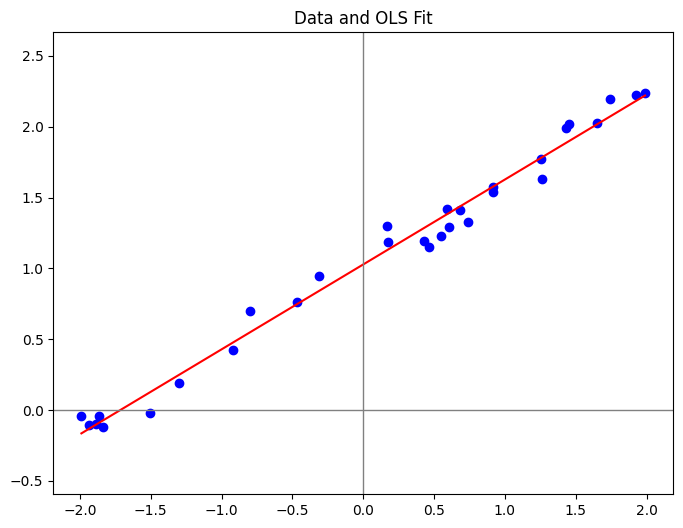

In [4]:
def add_bias(X):
    ones = np.ones((X.shape[0], 1))
    return np.column_stack((ones, X))

def ols(t):

    X_with_bias = add_bias(t['x'])  # Add bias term to X
    y = t['y']
    z, residuals, rank, s = np.linalg.lstsq(X_with_bias, y, rcond=None)  # Solve OLS
    return z


def plot_data_and_ols_fit(x, y, z):

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', label='Data Points')
    
    # Calculate the y-values of the best-fit line
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = z[0] + z[1] * x_vals
    
    plt.plot(x_vals, y_vals, color='red')
    
    # Plot the coordinate axes
    plt.axhline(0, color='gray', lw=1)
    plt.axvline(0, color='gray', lw=1)
    
    plt.axis('equal')
    plt.title('Data and OLS Fit')
    plt.show()

z = ols(noisy_line)
t = {'x': np.array([x for x in noisy_line['x']]), 'y': noisy_line['y']}
plot_data_and_ols_fit(t['x'], t['y'], z)

### Problem 1.2 (Exam Style Except for the Code)

In [5]:

def residuals(z, t):

    X, y = t['x'], t['y']
    X_bias = add_bias(X)  
    phi = np.tensordot(X_bias, z, axes=1) - y  
    J = X_bias  
    return phi, J

def quadratic_risk(z, t, order):

    phi, J = residuals(z, t)
    # print(phi.shape)
    # print((phi**2).shape)
    risk = np.mean(phi**2)
    # print(risk.shape)
    if order == 0:
        return risk
    elif order == 1:
        gradient = 2 / len(phi) * np.tensordot(J.T, phi, axes=1)
        return risk, gradient, None
    elif order == 2:
        gradient = 2 / len(phi) * np.tensordot(J.T, phi, axes=1)
        hessian = 2 / len(phi) * np.tensordot(J.T, J, axes=1)
        return risk, gradient, hessian


z0 = np.array([0, 0])


In [6]:
r, g, h = quadratic_risk(z0, t, 2)
print(f"Risk: \n{r:.3f}, \n Gradient:\n {g}, \n Hessian:\n {h}")

Risk: 
1.818, 
 Gradient:
 [-2.2201058  -2.23034973], 
 Hessian:
 [[2.         0.27481692]
 [0.27481692 3.24977035]]


### Problem 1.3

In [7]:
def descent(fct, z0, step, order, delta=1.e-6, max_iterations=1000, record=True):
    history = {'z': [z0], 'L': []}
    z = z0
    for i in range(max_iterations):
        r, g, h = fct(z, order)[:3]  # Get the gradient and Hessian matrix
        # print(f"r:{r}")
        z_next = step(fct, z, g, h)  # Calculate the next position
        if record:
            history['z'].append(z_next)
            # print(f"fct(z_next, 0):{fct(z_next, 0)}")
            history['L'].append(fct(z_next, 0))
        if np.linalg.norm(z_next - z) < delta or np.linalg.norm(g) < delta:
            break
        z = z_next
    else:
        print("Warning: Maximum iterations reached.")

    result = (z, fct(z, 0))
    if record:
        return result + (history,)
    return result


In [8]:
def newton_step(fct, z, g, h):
    h_inv = np.linalg.inv(h)  # Compute the inverse of the Hessian matrix
    step = np.tensordot(-h_inv , g, axes=1)  # Compute the step
    # print(f"step:{step}")
    return z + step

In [9]:

def plot_contours_and_path(fct, history, method_name):

    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([fct(np.array([xi, yi]), 0) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    
    plt.contour(X, Y, Z, levels=30, cmap='viridis')

    zs = np.array(history['z'])
    plt.plot(zs[:, 0], zs[:, 1], 'r-', marker='o', markersize=5)  # red curve for history path
    plt.plot(zs[:, 0], zs[:, 1], 'ro')  # visible dots at every zk
    plt.plot(zs[-1, 0], zs[-1, 1], 'kx', markersize=8)  # cross at the last point
    
    plt.axis('equal')
    solution = np.round(zs[-1], 3)  # Round the solution to three decimal places
    plt.title(f"Steps: {len(zs)-1}, Method: {method_name}, Solution: {solution}")
    plt.show()


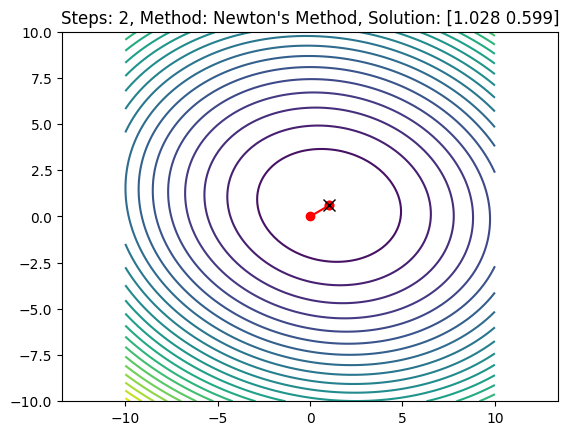

In [10]:

def risk_function(z, order):
    return quadratic_risk(z, t, order)

z0 = np.array([0, 0])
result, risk, history = descent(risk_function, z0, newton_step, 2, record=True)

plot_contours_and_path(risk_function, history, 'Newton\'s Method')

### Problem 1.4

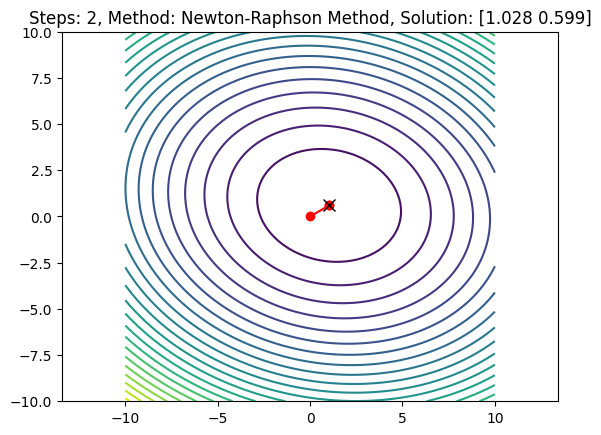

In [11]:

def newton_raphson(residual_fct, z0, delta=1.e-6, max_iterations=1000, record=True):
    if record:
        history = {'z': [z0], 'L': []}
    
    z = z0
    for i in range(max_iterations):
        residuals, J = residual_fct(z,t)  # compute the residuals and the Jacobian
        g = 2 * np.tensordot(J.T , residuals, axes=1)  # compute the gradient
        H = 2 * np.tensordot(J.T , J, axes=1)  # compute the Hessian
        step = np.tensordot(-np.linalg.inv(H) , g, axes=1) 
        z_next = z + step

        if record:
            history['z'].append(z_next)
            history['L'].append(np.mean(residuals**2))
        
        if np.linalg.norm(step) < delta:  # check for convergence
            break
        z = z_next

    if record:
        return z, np.mean(residual_fct(z,t)[0]**2), history
    return z, np.mean(residual_fct(z,t)[0]**2)

z0 = np.array([0, 0])
z, risk, history = newton_raphson(residuals, z0)

plot_contours_and_path(risk_function, history, 'Newton-Raphson Method')

### Problem 1.5

In [12]:
class GDStepper:
    def __init__(self, rate, momentum=0.0):
        self.rate = rate
        self.momentum = momentum
        self.velocity = 0.0

    def step(self, fct, z, g, h=None):
        self.velocity = self.momentum * self.velocity - self.rate * g
        return z + self.velocity

    def reset(self, rate=None, momentum=None):
        self.velocity = 0.0
        if rate is not None:
            self.rate = rate
        if momentum is not None:
            self.momentum = momentum


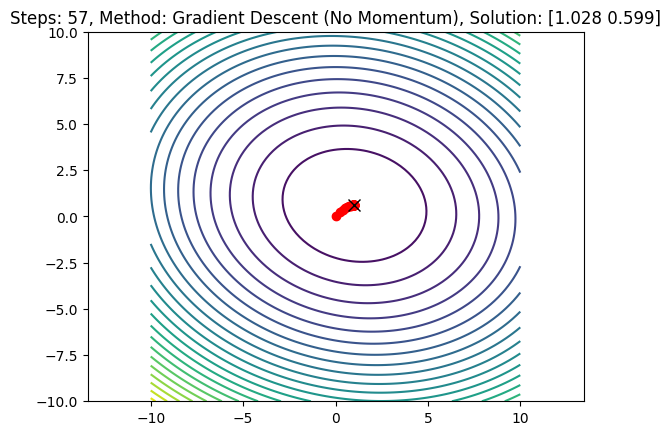

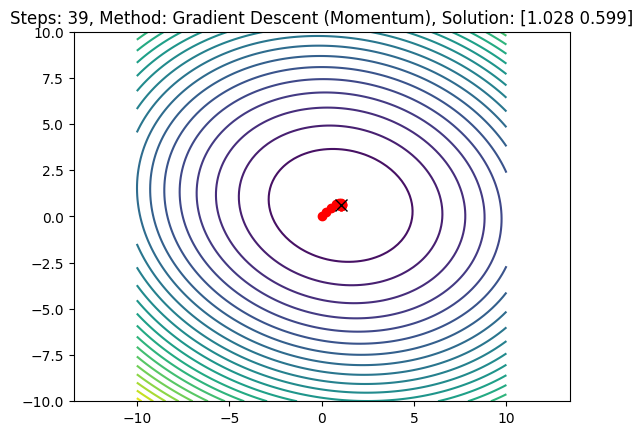

In [13]:

gd_stepper_no_momentum = GDStepper(rate=0.1, momentum=0.0)
z0 = np.array([0, 0])  
result, risk, history = descent(risk_function, z0, gd_stepper_no_momentum.step, 1, record=True)
plot_contours_and_path(risk_function, history, 'Gradient Descent (No Momentum)')

gd_stepper_with_momentum = GDStepper(rate=0.1, momentum=0.5)
gd_stepper_with_momentum.reset()  # Reset the velocity
result, risk, history = descent(risk_function, z0, gd_stepper_with_momentum.step, 1, record=True)
plot_contours_and_path(risk_function, history, 'Gradient Descent (Momentum)')


##### Where does momentum help and where does it hurt in this example?

In this example, momentum helps to accelerate convergence, allowing gradient descent to approach the optimal solution more rapidly.

##### How do the two versions of gradient descent compare with Newton's method in terms of the solution they obtain and the number of steps they perform for this example?

In terms of obtaining the solution and the number of execution steps, gradient descent with momentum approaches the optimal solution faster than gradient descent without momentum, because the momentum term helps overcome issues in local flat areas. Compared to the Newton method, gradient descent (whether with or without momentum) usually requires more iterations to achieve the same accuracy, as the Newton method utilizes information from the Hessian matrix to guide the search direction more precisely. However, each iteration of the Newton method has a higher computational cost.

##### Why does a larger number of steps not necessarily imply a longer running time in general (that is, for an arbitrary minimization task, not just for the example in this problem)?

In any minimization task, the running time of each step is a key factor. For instance, each step of gradient descent is typically faster to compute than a step of Newton's method, because the latter requires computing and inverting the Hessian matrix. Therefore, even if gradient descent requires more steps, the total running time can still be acceptable if the computational cost of each step is low.



## Part 2: Robust Hyperplane Fitting

In [14]:
import autograd.numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
def tukey(u, tau):
    inside = np.abs(u) <= tau
    tau2 = tau ** 2
    tau4 = tau2 ** 2
    u2 = u ** 2
    u4 = u2 ** 2
    u6 = u4 * u2
    out_value = tau ** 2 / 6
    in_values = u2 / 2 - u4 / 2 / tau2 + u6 / 6 / tau4
    rho = out_value * ~inside + in_values * inside
    return rho

In [16]:
file_name = 'two_noisy_lines.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    points = pickle.load(file)

Using previously downloaded file two_noisy_lines.pkl


In [17]:
def plot_fit(dots, f=None, title=None, sampling=100):
    px, py = dots[::sampling, 0], dots[::sampling, 1]
    fig_size = figure_size(4, px, py)
    plt.figure(figsize=fig_size, tight_layout=True)
    plt.plot(px, py, '.', ms=5)
    if f is not None:
        x_range = (np.min(dots[:, 0]), np.max(dots[:, 0]))
        x = np.linspace(x_range[0], x_range[1], 2)
        y = f(x)
        plt.plot(x, y)
    plt.axis('equal')
    plot_axes()
    if title is None:
        pct = 100 / sampling
        plt.title('{:g} percent of all points'.format(pct))
    else:
        plt.title(title)
    plt.draw()

In [18]:
retrieve('sgd.py')
from sgd import CallCounter, run_sgd, plot_fit

Using previously downloaded file sgd.py


### Problem 2.1

In [19]:

@CallCounter
def tukey_losses(z, x, tau):
    c, n = z[0], z[1:]
    phi = np.tensordot(x, n, axes=1) - c
    squared_term = (1 - (phi / tau)**2)**2
    # using the vectorized operation
    losses = np.where(abs(phi) <= tau, tau**2 / 6 * (1 - squared_term), tau**2 / 6)
    return losses


In [20]:

batch_size = 100  
learning_rate = 0.05  
# batch_size = 10  
# learning_rate = 0.01  
tau = 1.0 

run_sgd(tukey_losses, points, batch_size, learning_rate, tau=tau)


### Problem 2.2 (Exam Style)

This command uses the full dataset as a single batch, which essentially makes it a batch gradient descent rather than stochastic gradient descent. This differs from standard SGD, where each iteration only uses a small subset of the dataset (i.e., a mini-batch) to estimate the gradient and update parameters.

Since the entire dataset is used in every iteration, this process lacks the typical randomness of SGD. This method is more stable but may lead to slower convergence, especially when facing non-convex loss functions or large datasets.

### Problem 2.3 (Exam Style Except for the Code Run)

budget of 3000000 scalar calls exceeded
batch size = 210000, alpha = 0.01, evals = 3360000


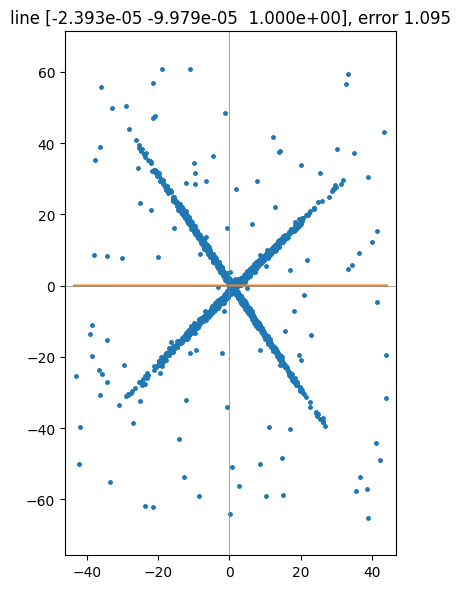

In [ ]:
run_sgd(tukey_losses, points, points.shape[0], 0.01)

For non-convex optimization problems, BGD is more likely to stop at a local minimum, especially if the loss function has multiple local minima. Due to its randomness, SGD, although not guaranteeing to find the global optimum every time, is more likely to find a "good" local optimum, especially when the loss function contains multiple local minima.